In [1]:
import pandas as pd
import jieba
import jieba.analyse
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
jieba.load_userdict("data/dict.txt")
jieba.analyse.set_stop_words('data/stop.txt') 
with open('data/stop.txt', 'rt',encoding="utf-8") as txt:
    stopword = txt.read()
stopword = stopword.split("\n")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\chloe\AppData\Local\Temp\jieba.cache
Loading model cost 2.236 seconds.
Prefix dict has been built succesfully.


In [3]:
def is_chinese(uchar):         
    if u'\u4e00' <= uchar<=u'\u9fff':
        return True
    else:
        return False

In [4]:
df = pd.read_csv("data/news.csv",encoding="utf-8")

In [5]:
df.head()

,time,source,url,txt
0,2018.05.01,聯合新聞網,https://udn.com/news/story/7315/3117728,日商百尺竿頭公司收購樂陞科技公司破局，2萬名投資人遭坑殺，樂陞董事長許金龍等10人被訴違反證...
1,2018.09.21?,鏡周刊,https://www.mirrormedia.mg/story/20180921inv013/,樂陞董事長許金龍遭控涉及樂陞炒股案，一審台北地院2月間依違反《證券交易法》等11罪，判許金龍...
2,2018.02.03,聯合新聞網,https://udn.com/news/story/11311/2965499,日商百尺竿頭公司收購樂陞科技公司破局，二萬名投資人遭坑殺，樂陞董事長許金龍等十人被起訴違反證...
3,2018.06.13?,鏡周刊,https://www.mirrormedia.mg/story/20180612inv009/,涉嫌樂陞炒股曾遭調查的股市金主陳聰明，近來悄悄重出江湖，5月中透過人頭狂買由影視大亨俞惟中成...
4,?2016.09.02,天下雜誌,https://www.cw.com.tw/article/articleLogin.act...,今年5月31日，樂陞科技大股東日商百尺竿頭數位娛樂有限公司，宣布將從公開市場以溢價22％的價...


In [6]:
corpus = []
for t in list(df.txt):
    cut = list(jieba.cut(t))
    txt = []
    for word in cut:
        save = False
        if word in stopword:
            continue
        for w in word:
            if is_chinese(w) == False:
                save = False
                break
            else:
                save = True
        if save == True:    
            txt.append(word)
    corpus.append(" ".join(txt))

In [7]:
vectorizer = TfidfVectorizer(min_df=1, stop_words = stopword)
tfidf = vectorizer.fit_transform(corpus)

In [8]:
words = vectorizer.get_feature_names()
print("len(words): ", len(words))

len(words):  6748


In [9]:
tfidf.shape

(94, 6748)

In [10]:
pca = PCA(n_components=2)
x = pca.fit_transform(tfidf.toarray())

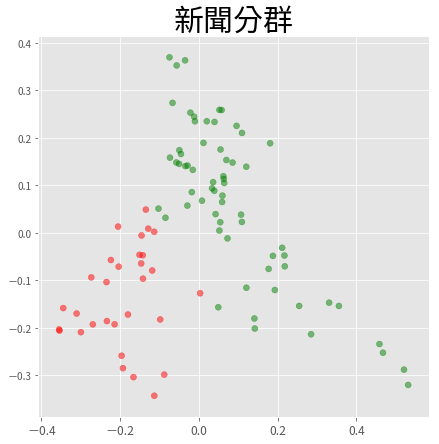

In [11]:
kmeans = KMeans(n_clusters =2)
#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x)
#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]
# Plot the scatter digram
plt.style.use('ggplot')
plt.rcParams["font.sans-serif"]=["Noto Sans CJK TC"]
plt.figure(figsize = (7,7))
plt.scatter(x[:,0],x[:,1], c= label_color , alpha=0.5)
plt.xticks(fontsize=12)
plt.title("新聞分群",fontsize=30)
plt.show()


In [12]:
df["cluster"] = X_clustered

In [13]:
c0 = df[df.cluster==0].source.value_counts(ascending=True).to_frame()
c1 = df[df.cluster==1].source.value_counts(ascending=True).to_frame()

# 新聞來源

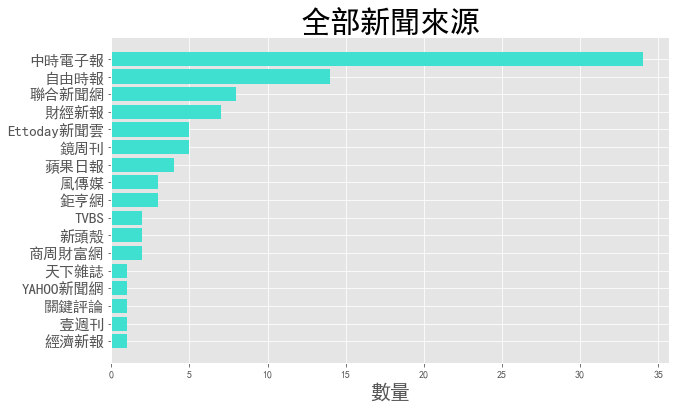

In [14]:
count = df.source.value_counts(ascending=True).to_frame()
plt.style.use('ggplot') 
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.figure(figsize=(10,6))
plt.barh(range(0,len(count)),count.source,color="turquoise")
plt.yticks(range(0,len(count)),count.index,fontsize=15)
plt.title("全部新聞來源",fontsize=30)
plt.xlabel("數量",fontsize=20)
plt.show()

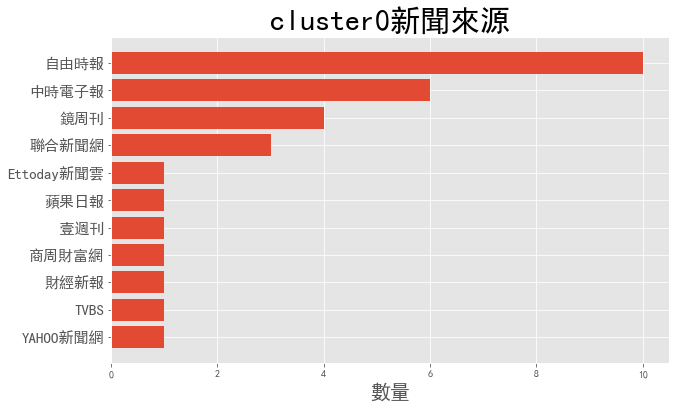

In [15]:
plt.style.use('ggplot') 
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.figure(figsize=(10,6))
plt.barh(range(0,len(c0)),c0.source)
plt.yticks(range(0,len(c0)),c0.index,fontsize=15)
plt.title("cluster0新聞來源",fontsize=30)
plt.xlabel("數量",fontsize=20)
plt.show()

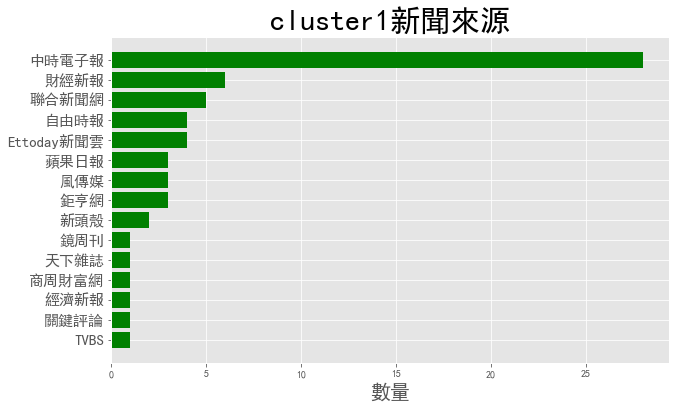

In [16]:
plt.style.use('ggplot') 
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.figure(figsize=(10,6))
plt.barh(range(0,len(c1)),c1.source,color="green")
plt.yticks(range(0,len(c1)),c1.index,fontsize=15)
plt.title("cluster1新聞來源",fontsize=30)
plt.xlabel("數量",fontsize=20)
plt.show()

# 文字雲

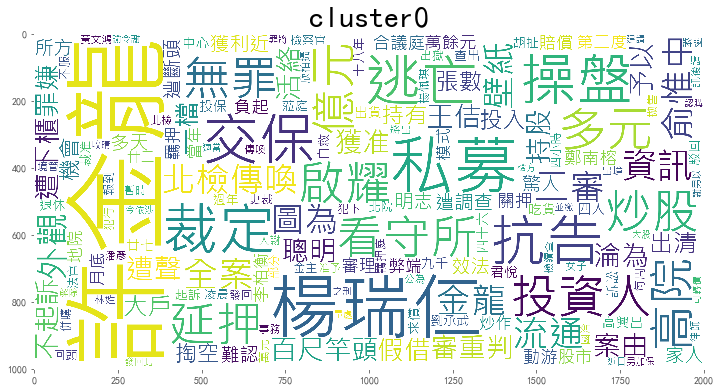

In [17]:
cluster0={}
n=0
for i in df[df.cluster==0].index:
    for j in range(len(words)):
        if tfidf[i,j] > 0.15:
            n+=1
            if words[j] in cluster0:
                cluster0[words[j]] = cluster0[words[j]] + 1
            else:
                cluster0[words[j]] = 1

wordcloud = WordCloud(background_color="white",width=2000, height=1000, margin=2,font_path = "C:\Windows\Fonts\msjh.ttc")
wordcloud.fit_words(cluster0)
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.figure(figsize=(12,10))
plt.title("cluster0",fontsize=30)
plt.grid(False)
plt.imshow(wordcloud)

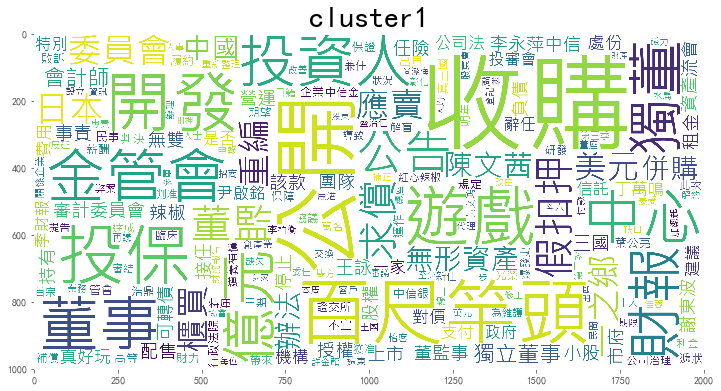

In [18]:
cluster1={}
n=0
for i in df[df.cluster==1].index:
    for j in range(len(words)):
        if tfidf[i,j] > 0.15:
            n+=1
            if words[j] in cluster1:
                cluster1[words[j]] = cluster1[words[j]] + 1
            else:
                cluster1[words[j]] = 1
wordcloud = WordCloud(background_color="white",width=2000, height=1000, margin=2,font_path = "C:\Windows\Fonts\msjh.ttc")
wordcloud.fit_words(cluster1)
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.figure(figsize=(12,10))
plt.title("cluster1",fontsize=30)
plt.grid(False)
plt.imshow(wordcloud)